# Part 2, Topic 3: Attacking Across MixColumns

**SUMMARY:** *In Part 2, Topic 2, you saw how to apply CPA attacks to a hardware implementaiton of AES. As it turns out, this attack will not work against many hardware implementations of AES. This is thanks to the fact that the implementation doesn't need to store the output ciphertext in the same register as the state. In this case, the nearest distance for the state register will usually be between the output of the 9th round and the output of the 8th round. Thanks to MixColumns, our leakage model will no longer depend on a single byte at a time, making our CPA attack completely infeasible.*

*In this lab, we'll examine and run a modified CPA attack, allowing our attack to succeed even with a MixColumns operation.*

**LEARNING OUTCOMES:**
* Understanding how the modified CPA attack allows attacks across MixColumns
* Using ChipWhisperer/SCARED to analyze traces

**NOTE:** This lab requires [SCARED](https://github.com/eshard/scared), which may be difficult to install on some systems (noteably Windows). If you're unable to install SCARED, you'll need to skip this lab.

Targets known to work with this leakage model:

* STM32F4
* STM32L4
* STM32L5
* K82F MMCAU
* CW305 Default AES Implementation
* MBEDTLS and TINYAES128C

A target with hardware AES is recommended as they often require this attack instead of a simpler attack; however, software AES is also vulnerable to this attack (though no more than a normal CPA attack)

To start with, let's take a look at an example AES implementation that the last round state diff we used in Lab 2_2 won't work for:

![](img/AES_MixCol.png)

AES operations are in orange, while registers are in purple. The mux before AddRoundKey allows the plaintext to be loaded at the beginning, as well as MixColumns to be skipped during the last round. As we can see, the demux after AddRoundKey stops the ciphertext from being put into the state register. Instead, if we work backwards from the ciphertext, we can see the two closest states will be the output of the 9th round and the output of the 8th round. The big issue that we run into is that MixColumns, as the name suggests, combines the 4 bytes of an AES state column together. Up to that point, each byte was completely independent of one another, meaning we could also evaluate each byte independently, turning a $2^{128}$ search into 16 $2^8$ searches. Now, with MixColumns, we need to evaluate 4 bytes at a time, giving us 4 $2^{32}$ searches. 

Attacking from the plaintext side is no better - the MixColumns is still there. Does that mean if we cross a MixColumns in our leakage model, our attack is thwarted? Luckily, the answer to this is no! Instead of doing a full random plaintext like our usual attack, let's instead make all the bytes except for a column or row constant and we'll walk through the start of AES:

$
\left[\begin{array}{llll}
v_0 & v_1 & v_2 & v_3 \\
c_0 & c_3 & c_6 & c_9 \\
c_1 & c_4 & c_7 & c_{10} \\
c_2 & c_5 & c_8 & c_{11}
\end{array}\right]$

Thanks to shift rows, that will give us 3 constant bytes and 1 variable byte in each column (everything is $'$ here because of SubBytes):

$
\left[\begin{array}{llll}
v'_0 & v'_1 & v'_2 & v'_3 \\
c'_3 & c'_6 & c'_9 & c'_0 \\
c'_7 & c'_{10} & c'_1 & c'_{4} \\
c'_{11} & c'_2 & c'_5 & c'_{8}
\end{array}\right]$

MixColumns (on a single column) is the following operation ($v$ is the variable byte, $c_n$ are the constants). Note that the input of MixColumns is really just the output of SubBytes, our usual attack point, since ShiftRows doesn't modify the values, it just moves them:

$\left[\begin{array}{l}
d_{0} \\
d_{1} \\
d_{2} \\
d_{3}
\end{array}\right]=\left[\begin{array}{llll}
2 & 3 & 1 & 1 \\
1 & 2 & 3 & 1 \\
1 & 1 & 2 & 3 \\
3 & 1 & 1 & 2
\end{array}\right]\left[\begin{array}{l}
v'_0 \\
c'_{3} \\
c'_{7} \\
c'_{11}
\end{array}\right]$

$d_0$, for example, will be:

$d_0 = 2v'_0 + 3c'_3 + c'_7 + c'_{11}$

We can combine the three constants into a single constant:

$d_0 = 2v'_0 + c_a$

It might not be immediately obvious, but this has actually taken our $2^{32}$ attack down to $2^{16}$! If $c_a$ wasn't there, this would pretty much just be our regular CPA attack, so doing a CPA attack for each possible value of $c_a$ should allow us to to recover the key! This constant we've combined everything into is actually extremely powerful: any constants XOR'd ($+$) with with the SBox output will completely disappear, meaning the AddRoundKey following MixColumns is also eliminated! It is due to this fact that this attack will work against many different target implementations, including software AES, STM32F4 style implementations (which was vulnerable to last round state diff), and many models resistant to last round state diff.

While this seems very promising, it does suffer from a few issues:

1. $2^{16}$ is still a fairly large search space, meaning our attack will take a very long time
1. $c$ is only being XOR'd here, which means we'll run into ghost peaks
1. This XOR also means the correct and incorrect values for $c$ will have very similar correlations.

Instead, we can attack $v'$ one bit at a time. This is very similar to a single bit DPA attack, except we're still using correlation instead of the difference. Now the constant will only have the effect of inverting the correlation (if that constant bit is 1) or not inverting it (if that constant bit is 0). This means we can completely remove the effect of the constant by taking the absolute value of the correlation, taking us back to a $2^8$ attack! We also don't have to worry about the ghost peaks or the similar correlations for $c_a$.

As you might expect, on its own this attack works very poorly - 1 bit is not enough information for a CPA attack. Much better is to perform the attack on each bit of $2v$ and sum the absolute correlations. This isn't the only spot $v$ shows up though! We also have the other $d$ values:

$d_1 = v'_0 + 2c'_3 + 3c'_7 + c'_{11} = v'_0 + c_b$

$d_2 = v'_0 + c'_3 + 2c'_7 + 3c'_{11} = v'_0 + c_c$

$d_3 = 3v'_0 + c'_3 + c'_7 + 2c'_{11} = 3v'_0 + c_d$

Adding in these brings us up to 32 CPA attacks. If we only needed Hamming weight, this would be pretty simple, with our leakage model being:

`h = ((2*sbox(pt0 + key0)>>bit) & 0x01`

Things get a bit trickier with the Hamming distance. The key can be incorporated into $c$ since it's constant. However, we need to line up the MixColumns output with the correct byte in the input. This is still simple with the top byte of each column ($d_0$ lines up with $p_0$, $d_1$ lines up with $p_1$, and so on), but later bytes get shifted by ShiftRows. For example, attacking $k_1$, $d_0$ will line up with $p_{12}$, $d_1$ will line up with $p_{13}$ and so on. They also have a different order in MixColumns - $p_0$ goes 2, 1, 1, 3, but $p_1$ goes 3, 2, 1, 1.

Aside from being more complicated than our usual CPA attack, this attack also has the disadvantage of only targeting 4 key bytes per capture campaign, since the other bytes in the AES column have to be constant. It's also a fairly lengthy analysis since we need to do $32 \times 4$ = 128 CPA attacks to recover all 16 key bytes.

As an aside, if we didn't need to go through ARK1, we could make a big optimization on the attack. We can actually calculate the constant values by using the sign of each correlation. These constants can then be used to calculate the corresponding key from a system of equations. This version of the attack is detailed in https://eprint.iacr.org/2019/343.pdf. This paper also details an optimization that would allow us to bring the attack down to a single capture campaign, as well as extensions to AES-192 and AES-256, though we won't take a look at either of these extensions in this lab.

This attack was originally detailed in https://eprint.iacr.org/2016/249.pdf by Amir Moradi and Tobias Schneider. Many thanks to them for the theory behind this tutorial!

## Setup

In [1]:
import chipwhisperer as cw
scope = cw.scope()

In [2]:
target = cw.target(scope, cw.targets.CW305, fpga_id='35t', force=False)

In [3]:
scope.gain.db = 25
scope.adc.samples = 129
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "disabled"

In [4]:
target.vccint_set(1.0)
# we only need PLL1:
target.pll.pll_enable_set(True)
target.pll.pll_outenable_set(False, 0)
target.pll.pll_outenable_set(True, 1)
target.pll.pll_outenable_set(False, 2)

# run at 10 MHz:
target.pll.pll_outfreq_set(10E6, 1)

# 1ms is plenty of idling time
target.clkusbautooff = True
target.clksleeptime = 1

In [5]:
if scope._is_husky:
    scope.clock.clkgen_freq = 40e6
    scope.clock.clkgen_src = 'extclk'
    scope.clock.adc_mul = 4
    # if the target PLL frequency is changed, the above must also be changed accordingly
else:
    scope.clock.adc_src = "extclk_x4"

In [6]:
scope.clock.reset_adc()
assert (scope.clock.adc_locked), "ADC failed to lock"

In [7]:
scope

cwlite Device
sn         = 50203220313038543030393131313039
fw_version = 
    major = 0
    minor = 52
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 129
    decimate       = 1
    trig_count     = 920196490
    fifo_fill_mode = normal
clock = 
    adc_src       = extclk_x4
    adc_phase     = 0
    adc_freq      = 40001403
    adc_rate      = 40001403.0
    adc_locked    = True
    freq_ctr      = 10000350
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 1
    clkgen_freq   = 192000000.0
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
 

## Capture

For capture, we need to do four separate capture campaigns to recover the key, since we're only targeting 4 bytes at a time. ChipWhisperer includes a special key-text pair to change out which parts of the plaintext are constant and which are variable.

In [8]:
from tqdm.notebook import trange
import numpy as np
from Crypto.Cipher import AES

vec_type = 'row'
ktp = cw.ktp.VarVec(vec_type=vec_type)
key, pt = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)

N = 5000
projects = []


for cmpgn in trange(4):
    project = cw.create_project(f"Var_Vec_{cmpgn}", overwrite=True)
    projects.append(project)
    for i in trange(N, leave=False):
        ktp.var_vec = cmpgn
        key, text = ktp.next()
        ret = cw.capture_trace(scope, target, text, key)
        if not ret :
            print("Failed Capture")
            continue
        assert (list(ret.textout) == list(cipher.encrypt(bytes(text)))), "Incorrect encryption result!\nGot {}\nExp {}\n".format(ret.textout, list(cipher.encrypt(bytes(text))))
        project.traces.append(ret)
    project.save()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

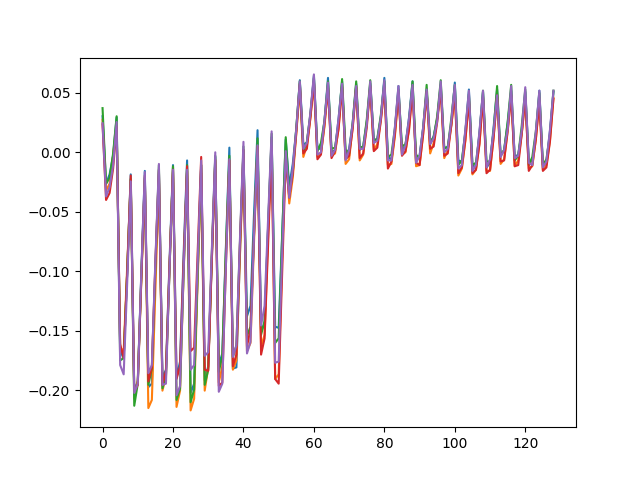

In [9]:
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.figure()
for i in range(5):
    plt.plot(projects[0].waves[i])
    
plt.show()

## Analysis

If you closed the project, reopen it now:

In [1]:
import chipwhisperer as cw
projects = []
for i in range(4):
    project = cw.open_project(f"Var_Vec_{i}")
    projects.append(project)

ChipWhisperer/SCARED will take care all of the analysis for us here. You can adjust the number of traces you use with `n_traces`. Windowing can also be very important with this attack. You can adjust the window you analyzer with `trace_slice`.

In [ ]:
# import chipwhisperer.common.api.lascar as cw_lascar
# from lascar import *
# container = cw_lascar.CWContainer(project, project.textouts)
# cpa_egnines = [CpaEngine("kippo", cw_lascar.lastround_HD_gen(i), range(256)) for i in range(16)]
# session = Session(container, engines=cpa_egnines).run(batch_size=1000)

In [3]:
from chipwhisperer.analyzer.attacks.attack_mix_columns import AttackMixColumns
vec_type = 'row'
attack = AttackMixColumns(projects, vec_type=vec_type, hd=False)
results = attack.run(n_traces=None, trace_slice=slice(0, 80))

  0%|          | 0/4 [00:00<?, ?it/s]







































 25%|██▌       | 1/4 [00:14<00:44, 14.94s/it]







































 50%|█████     | 2/4 [00:28<00:28, 14.11s/it]







































 75%|███████▌  | 3/4 [00:42<00:14, 14.02s/it]







































100%|██████████| 4/4 [00:56<00:00, 14.19s/it]


In [4]:
print(bytearray(results["guess"]))
print(bytearray(projects[0].keys[0]))

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


Let's plot the correlations of the best guess/key or second best guess/key:

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Best guess 0x2b (corr=2.456490993499756), next best = 1.297200083732605, real = 2.456490993499756
Best guess 0x7e (corr=2.94264554977417), next best = 1.2465821504592896, real = 2.94264554977417
Best guess 0x15 (corr=2.8804707527160645), next best = 1.29072105884552, real = 2.8804707527160645
Best guess 0x16 (corr=1.9474867582321167), next best = 0.950891375541687, real = 1.9474867582321167
Best guess 0x28 (corr=2.6258528232574463), next best = 1.3982880115509033, real = 2.6258528232574463
Best guess 0xae (corr=2.621013641357422), next best = 1.1224693059921265, real = 2.621013641357422
Best guess 0xd2 (corr=2.6873221397399902), next best = 1.2063305377960205, real = 2.6873221397399902
Best guess 0xa6 (corr=3.293616771697998), next best = 1.4841253757476807, real = 3.293616771697998
Best guess 0xab (corr=2.4700400829315186), next best = 1.434525728225708, real = 2.4700400829315186
Best guess 0xf7 (corr=2.8282575607299805), next best = 1.2842378616333008, real = 2.8282575607299805
Best 

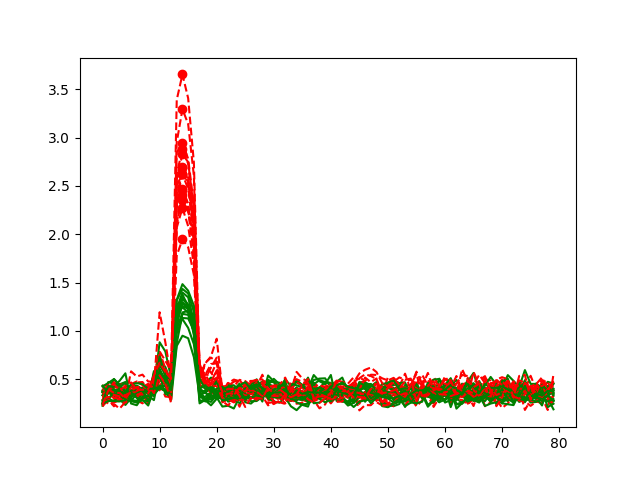

In [5]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
for i in range(16):
    c = results["corr"][i]
    maxes = np.max(c, axis=1)
    guess = np.argsort(maxes)[-1]
    guess2 = np.argsort(maxes)[-2]
    actual = projects[0].keys[0][i]
    x = np.argmax(c[actual])
    if guess != actual:
        plt.plot(c[guess], "g-")
    else:
        plt.plot(c[guess2], "g-")
    plt.plot(c[actual], "r--")
    plt.plot(x, c[actual][x], "ro")
    print(f"Best guess {hex(guess)} (corr={maxes[guess]}), next best = {maxes[guess2]}, real = {maxes[actual]}")
plt.show()

## Original Implementations

Provided for reference.

In [7]:
%%time
import scared
import numpy as np
b = None
gal2=np.array((
0x00,0x02,0x04,0x06,0x08,0x0a,0x0c,0x0e,0x10,0x12,0x14,0x16,0x18,0x1a,0x1c,0x1e,
0x20,0x22,0x24,0x26,0x28,0x2a,0x2c,0x2e,0x30,0x32,0x34,0x36,0x38,0x3a,0x3c,0x3e,
0x40,0x42,0x44,0x46,0x48,0x4a,0x4c,0x4e,0x50,0x52,0x54,0x56,0x58,0x5a,0x5c,0x5e,
0x60,0x62,0x64,0x66,0x68,0x6a,0x6c,0x6e,0x70,0x72,0x74,0x76,0x78,0x7a,0x7c,0x7e,
0x80,0x82,0x84,0x86,0x88,0x8a,0x8c,0x8e,0x90,0x92,0x94,0x96,0x98,0x9a,0x9c,0x9e,
0xa0,0xa2,0xa4,0xa6,0xa8,0xaa,0xac,0xae,0xb0,0xb2,0xb4,0xb6,0xb8,0xba,0xbc,0xbe,
0xc0,0xc2,0xc4,0xc6,0xc8,0xca,0xcc,0xce,0xd0,0xd2,0xd4,0xd6,0xd8,0xda,0xdc,0xde,
0xe0,0xe2,0xe4,0xe6,0xe8,0xea,0xec,0xee,0xf0,0xf2,0xf4,0xf6,0xf8,0xfa,0xfc,0xfe,
0x1b,0x19,0x1f,0x1d,0x13,0x11,0x17,0x15,0x0b,0x09,0x0f,0x0d,0x03,0x01,0x07,0x05,
0x3b,0x39,0x3f,0x3d,0x33,0x31,0x37,0x35,0x2b,0x29,0x2f,0x2d,0x23,0x21,0x27,0x25,
0x5b,0x59,0x5f,0x5d,0x53,0x51,0x57,0x55,0x4b,0x49,0x4f,0x4d,0x43,0x41,0x47,0x45,
0x7b,0x79,0x7f,0x7d,0x73,0x71,0x77,0x75,0x6b,0x69,0x6f,0x6d,0x63,0x61,0x67,0x65,
0x9b,0x99,0x9f,0x9d,0x93,0x91,0x97,0x95,0x8b,0x89,0x8f,0x8d,0x83,0x81,0x87,0x85,
0xbb,0xb9,0xbf,0xbd,0xb3,0xb1,0xb7,0xb5,0xab,0xa9,0xaf,0xad,0xa3,0xa1,0xa7,0xa5,
0xdb,0xd9,0xdf,0xdd,0xd3,0xd1,0xd7,0xd5,0xcb,0xc9,0xcf,0xcd,0xc3,0xc1,0xc7,0xc5,
0xfb,0xf9,0xff,0xfd,0xf3,0xf1,0xf7,0xf5,0xeb,0xe9,0xef,0xed,0xe3,0xe1,0xe7,0xe5), dtype='uint8')

gal3=np.array((
0x00,0x03,0x06,0x05,0x0c,0x0f,0x0a,0x09,0x18,0x1b,0x1e,0x1d,0x14,0x17,0x12,0x11,
0x30,0x33,0x36,0x35,0x3c,0x3f,0x3a,0x39,0x28,0x2b,0x2e,0x2d,0x24,0x27,0x22,0x21,
0x60,0x63,0x66,0x65,0x6c,0x6f,0x6a,0x69,0x78,0x7b,0x7e,0x7d,0x74,0x77,0x72,0x71,
0x50,0x53,0x56,0x55,0x5c,0x5f,0x5a,0x59,0x48,0x4b,0x4e,0x4d,0x44,0x47,0x42,0x41,
0xc0,0xc3,0xc6,0xc5,0xcc,0xcf,0xca,0xc9,0xd8,0xdb,0xde,0xdd,0xd4,0xd7,0xd2,0xd1,
0xf0,0xf3,0xf6,0xf5,0xfc,0xff,0xfa,0xf9,0xe8,0xeb,0xee,0xed,0xe4,0xe7,0xe2,0xe1,
0xa0,0xa3,0xa6,0xa5,0xac,0xaf,0xaa,0xa9,0xb8,0xbb,0xbe,0xbd,0xb4,0xb7,0xb2,0xb1,
0x90,0x93,0x96,0x95,0x9c,0x9f,0x9a,0x99,0x88,0x8b,0x8e,0x8d,0x84,0x87,0x82,0x81,
0x9b,0x98,0x9d,0x9e,0x97,0x94,0x91,0x92,0x83,0x80,0x85,0x86,0x8f,0x8c,0x89,0x8a,
0xab,0xa8,0xad,0xae,0xa7,0xa4,0xa1,0xa2,0xb3,0xb0,0xb5,0xb6,0xbf,0xbc,0xb9,0xba,
0xfb,0xf8,0xfd,0xfe,0xf7,0xf4,0xf1,0xf2,0xe3,0xe0,0xe5,0xe6,0xef,0xec,0xe9,0xea,
0xcb,0xc8,0xcd,0xce,0xc7,0xc4,0xc1,0xc2,0xd3,0xd0,0xd5,0xd6,0xdf,0xdc,0xd9,0xda,
0x5b,0x58,0x5d,0x5e,0x57,0x54,0x51,0x52,0x43,0x40,0x45,0x46,0x4f,0x4c,0x49,0x4a,
0x6b,0x68,0x6d,0x6e,0x67,0x64,0x61,0x62,0x73,0x70,0x75,0x76,0x7f,0x7c,0x79,0x7a,
0x3b,0x38,0x3d,0x3e,0x37,0x34,0x31,0x32,0x23,0x20,0x25,0x26,0x2f,0x2c,0x29,0x2a,
0x0b,0x08,0x0d,0x0e,0x07,0x04,0x01,0x02,0x13,0x10,0x15,0x16,0x1f,0x1c,0x19,0x1a), dtype='uint8')



w=0x00
lut_input = [[0, 1, 2, 3],
        [4, 5, 6, 7],
        [8, 9, 10, 11],
        [12, 13, 14, 15]]

def round_gen_0(plaintext, guesses, cmpgn):
    lut_mix_column = [[0, 13, 10, 7],
                     [4, 1, 14, 11],
                     [8, 5, 2, 15],
                     [12, 9, 6, 3]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, gal2[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

def round_gen_1(plaintext, guesses, cmpgn):
    lut_mix_column = [[1, 14, 11, 4],
                     [5, 2, 15, 8],
                     [9, 6, 3, 12],
                     [13, 10, 7, 0]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_2(plaintext, guesses, cmpgn):
    lut_mix_column = [[2, 15, 8, 5],
                     [6, 3, 12, 9],
                     [10, 7, 0, 13],
                     [14, 1, 4, 1]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_3(plaintext, guesses, cmpgn):
    lut_mix_column = [[3, 12, 9, 6],
                     [7, 0, 13, 10],
                     [11, 4, 14, 1],
                     [15, 8, 5, 2]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, gal3[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

leakage_cmpgns = []
for campaign in range(4):
    leakage_cmpgns.append([scared.attack_selection_function(lambda plaintext, guesses: round_gen_0(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_1(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_2(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_3(plaintext, guesses, campaign))])

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 2.24 ms


In [8]:
import tqdm.autonotebook

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0x2b (corr=2.456490993499756), next best = 1.297200083732605, real = 2.456490993499756
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xae (corr=2.6210134029388428), next best = 1.122469425201416, real = 2.6210134029388428
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0x15 (corr=2.2719826698303223), next best = 1.177172064781189, real = 2.2719826698303223
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/distinguishers/cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/scared/discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0xff (corr=0.0), next best = 0.0, real = 0.0
Best guess 0x3c (corr=2.358452796936035), next best = 1.134334921836853, real = 2.358452796936035


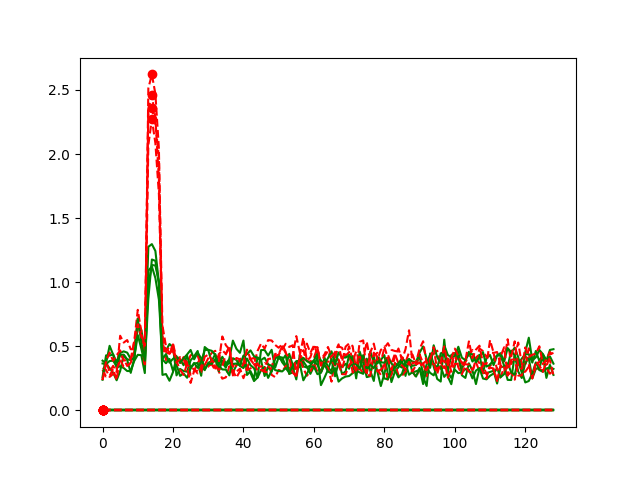

In [13]:
import estraces, scared
import numpy as np
from tqdm.notebook import trange
#del cw_traces
campaign = 0
n_traces = 5000
key_guess = []
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.figure()
    


for campaign in trange(0,4):
    b = None
    cw_traces = estraces.read_ths_from_ram(np.array(projects[campaign].waves)[:n_traces,:], 
                                      plaintext=np.array([textin for textin in projects[campaign].textins], dtype='uint8')[:n_traces])
    #cw_traces = estraces.read_ths_from_ram(np.array(projects[campaign].waves)[:n_traces,550:900], 
    #                                  plaintext=np.array([textin for textin in projects[campaign].textins], dtype='uint8')[:n_traces])
    for t in trange(4, leave=False):
        for i in trange(8, leave=False):
            container = scared.Container(cw_traces)
            a = scared.CPAAttack(selection_function=leakage_cmpgns[campaign][t],
                                model=scared.Monobit(i),
                                discriminant=scared.maxabs)


            a.run(container)
            if b is None:
                b = abs(a.results)
            else:
                b += abs(a.results)
    for i in range(0+4*campaign, 4+4*campaign):
        c = np.nan_to_num(b[:,i,:])
        maxes = np.max(c, axis=1)
        guess = np.argsort(maxes)[-1]
        guess2 = np.argsort(maxes)[-2]
        actual = projects[0].keys[0][i]
        x = np.argmax(c[actual])
        if guess != actual:
            plt.plot(c[guess], "g-")
        else:
            plt.plot(c[guess2], "g-")
        plt.plot(c[actual], "r--")
        plt.plot(x, c[actual][x], "ro")
        print(f"Best guess {hex(guess)} (corr={maxes[guess]}), next best = {maxes[guess2]}, real = {maxes[actual]}")
        key_guess.append(guess)

plt.show()

In [14]:
print(bytearray(key_guess))
print(bytearray(projects[0].keys[0]))

CWbytearray(b'2b ff ff ff ff ae ff ff ff ff 15 ff ff ff ff 3c')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


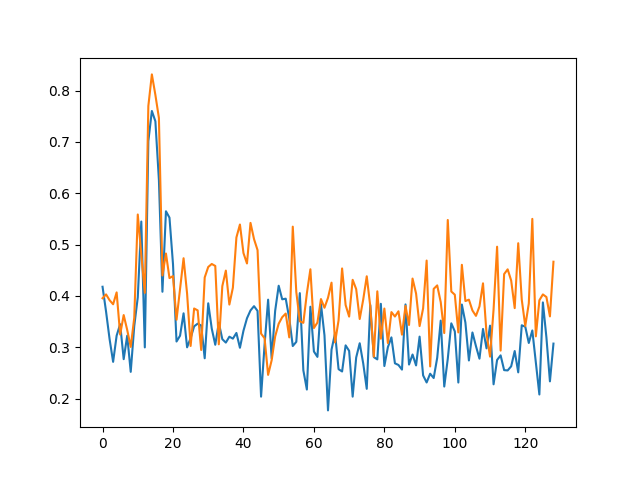

In [15]:
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.figure()
plt.plot(c[0x16])
plt.plot(c[0x7f])
    
plt.show()

/home/antragoudaras/test_my_chipwhisperer/venv/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


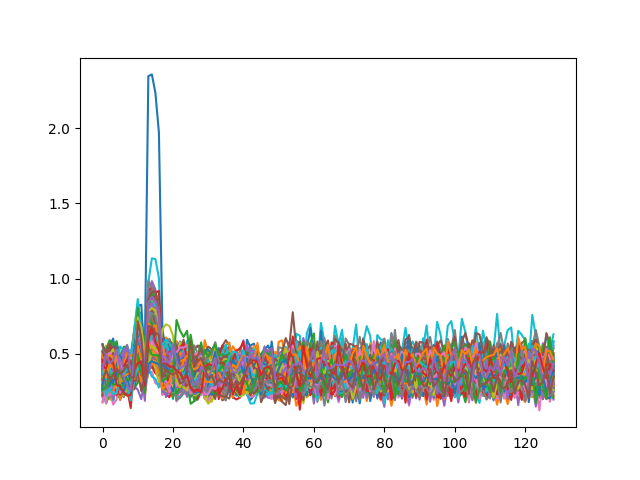

In [16]:
%matplotlib ipympl
import matplotlib.pyplot as plt
plt.figure()
for i in range(256):
    plt.plot(c[i])
    
plt.show()

In [17]:
%%time
import scared
import numpy as np
gal2=np.array((
0x00,0x02,0x04,0x06,0x08,0x0a,0x0c,0x0e,0x10,0x12,0x14,0x16,0x18,0x1a,0x1c,0x1e,
0x20,0x22,0x24,0x26,0x28,0x2a,0x2c,0x2e,0x30,0x32,0x34,0x36,0x38,0x3a,0x3c,0x3e,
0x40,0x42,0x44,0x46,0x48,0x4a,0x4c,0x4e,0x50,0x52,0x54,0x56,0x58,0x5a,0x5c,0x5e,
0x60,0x62,0x64,0x66,0x68,0x6a,0x6c,0x6e,0x70,0x72,0x74,0x76,0x78,0x7a,0x7c,0x7e,
0x80,0x82,0x84,0x86,0x88,0x8a,0x8c,0x8e,0x90,0x92,0x94,0x96,0x98,0x9a,0x9c,0x9e,
0xa0,0xa2,0xa4,0xa6,0xa8,0xaa,0xac,0xae,0xb0,0xb2,0xb4,0xb6,0xb8,0xba,0xbc,0xbe,
0xc0,0xc2,0xc4,0xc6,0xc8,0xca,0xcc,0xce,0xd0,0xd2,0xd4,0xd6,0xd8,0xda,0xdc,0xde,
0xe0,0xe2,0xe4,0xe6,0xe8,0xea,0xec,0xee,0xf0,0xf2,0xf4,0xf6,0xf8,0xfa,0xfc,0xfe,
0x1b,0x19,0x1f,0x1d,0x13,0x11,0x17,0x15,0x0b,0x09,0x0f,0x0d,0x03,0x01,0x07,0x05,
0x3b,0x39,0x3f,0x3d,0x33,0x31,0x37,0x35,0x2b,0x29,0x2f,0x2d,0x23,0x21,0x27,0x25,
0x5b,0x59,0x5f,0x5d,0x53,0x51,0x57,0x55,0x4b,0x49,0x4f,0x4d,0x43,0x41,0x47,0x45,
0x7b,0x79,0x7f,0x7d,0x73,0x71,0x77,0x75,0x6b,0x69,0x6f,0x6d,0x63,0x61,0x67,0x65,
0x9b,0x99,0x9f,0x9d,0x93,0x91,0x97,0x95,0x8b,0x89,0x8f,0x8d,0x83,0x81,0x87,0x85,
0xbb,0xb9,0xbf,0xbd,0xb3,0xb1,0xb7,0xb5,0xab,0xa9,0xaf,0xad,0xa3,0xa1,0xa7,0xa5,
0xdb,0xd9,0xdf,0xdd,0xd3,0xd1,0xd7,0xd5,0xcb,0xc9,0xcf,0xcd,0xc3,0xc1,0xc7,0xc5,
0xfb,0xf9,0xff,0xfd,0xf3,0xf1,0xf7,0xf5,0xeb,0xe9,0xef,0xed,0xe3,0xe1,0xe7,0xe5), dtype='uint8')

gal3=np.array((
0x00,0x03,0x06,0x05,0x0c,0x0f,0x0a,0x09,0x18,0x1b,0x1e,0x1d,0x14,0x17,0x12,0x11,
0x30,0x33,0x36,0x35,0x3c,0x3f,0x3a,0x39,0x28,0x2b,0x2e,0x2d,0x24,0x27,0x22,0x21,
0x60,0x63,0x66,0x65,0x6c,0x6f,0x6a,0x69,0x78,0x7b,0x7e,0x7d,0x74,0x77,0x72,0x71,
0x50,0x53,0x56,0x55,0x5c,0x5f,0x5a,0x59,0x48,0x4b,0x4e,0x4d,0x44,0x47,0x42,0x41,
0xc0,0xc3,0xc6,0xc5,0xcc,0xcf,0xca,0xc9,0xd8,0xdb,0xde,0xdd,0xd4,0xd7,0xd2,0xd1,
0xf0,0xf3,0xf6,0xf5,0xfc,0xff,0xfa,0xf9,0xe8,0xeb,0xee,0xed,0xe4,0xe7,0xe2,0xe1,
0xa0,0xa3,0xa6,0xa5,0xac,0xaf,0xaa,0xa9,0xb8,0xbb,0xbe,0xbd,0xb4,0xb7,0xb2,0xb1,
0x90,0x93,0x96,0x95,0x9c,0x9f,0x9a,0x99,0x88,0x8b,0x8e,0x8d,0x84,0x87,0x82,0x81,
0x9b,0x98,0x9d,0x9e,0x97,0x94,0x91,0x92,0x83,0x80,0x85,0x86,0x8f,0x8c,0x89,0x8a,
0xab,0xa8,0xad,0xae,0xa7,0xa4,0xa1,0xa2,0xb3,0xb0,0xb5,0xb6,0xbf,0xbc,0xb9,0xba,
0xfb,0xf8,0xfd,0xfe,0xf7,0xf4,0xf1,0xf2,0xe3,0xe0,0xe5,0xe6,0xef,0xec,0xe9,0xea,
0xcb,0xc8,0xcd,0xce,0xc7,0xc4,0xc1,0xc2,0xd3,0xd0,0xd5,0xd6,0xdf,0xdc,0xd9,0xda,
0x5b,0x58,0x5d,0x5e,0x57,0x54,0x51,0x52,0x43,0x40,0x45,0x46,0x4f,0x4c,0x49,0x4a,
0x6b,0x68,0x6d,0x6e,0x67,0x64,0x61,0x62,0x73,0x70,0x75,0x76,0x7f,0x7c,0x79,0x7a,
0x3b,0x38,0x3d,0x3e,0x37,0x34,0x31,0x32,0x23,0x20,0x25,0x26,0x2f,0x2c,0x29,0x2a,
0x0b,0x08,0x0d,0x0e,0x07,0x04,0x01,0x02,0x13,0x10,0x15,0x16,0x1f,0x1c,0x19,0x1a), dtype='uint8')



w=0x00
lut_input = [[0, 1, 2, 3],
        [4, 5, 6, 7],
        [8, 9, 10, 11],
        [12, 13, 14, 15]]

def round_gen_0(plaintext, guesses, cmpgn):
    lut_mix_column = [[0, 4, 8, 12],
                     [13, 1, 5, 9],
                     [10, 14, 2, 6],
                     [7, 11, 15, 3]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, gal2[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

def round_gen_1(plaintext, guesses, cmpgn):
    lut_mix_column = [[1, 5, 9, 13],
                     [14, 2, 6, 10],
                     [11, 15, 3, 7],
                     [4, 8, 12, 0]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_2(plaintext, guesses, cmpgn):
    lut_mix_column = [[2, 6, 10, 14],
                     [15, 3, 7, 11],
                     [8, 12, 0, 4],
                     [5, 9, 13, 1]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_3(plaintext, guesses, cmpgn):
    lut_mix_column = [[3, 7, 11, 15],
                     [12, 0, 4, 8],
                     [9, 13, 1, 5],
                     [6, 10, 14, 2]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, gal3[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

leakage_cmpgns = []
for campaign in range(4):
    leakage_cmpgns.append([scared.attack_selection_function(lambda plaintext, guesses: round_gen_0(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_1(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_2(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_3(plaintext, guesses, campaign))])

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.82 ms
